# Hyperparameter Tuning on Feature Selection, Ensemble Regressor & Kaggle Submissions

In the following steps, we will focus on tuning the top-performing models (**XGBRegressor**, **LGBMRegressor**, and **HistGradientBoostingRegressor**) using the refined feature subset derived from the SHAP analysis.

In [ ]:
# Import required Libraries
import os
import pandas as pd
from tqdm import tqdm

# Import custom classes for hyper-parameter tunning
# NOTE: Below, PATH_TO_PROJECT is the location of the project folder (e.g: /home/sep24_bds_int_medical)
import sys

PATH_TO_SRC = 'PATH_TO_PROJECT/sep24_bds_int_medical'
sys.path.append(PATH_TO_SRC)

from src.features.tuners.XGBHyperparameterTuner import XGBHyperparameterTuner
from src.features.tuners.LGBMHyperparameterTuner import LGBMHyperparameterTuner
from src.features.tuners.HistGradientBoostingHyperparameterTuner import HistGradientBoostingHyperparameterTuner
from src.features.tuners.LassoCVHyperparameterTuner import LassoCVHyperparameterTuner
from src.features.tuners.RidgeHyperparameterTuner import RidgeHyperparameterTuner
from src.features.tuners.KNeighborsHyperparameterTuner import KNeighborsHyperparameterTuner

# Import Dummy Regressor
from sklearn.dummy import DummyRegressor

# Import the preprocessing pipeline
from pipelines import *

# Disable warnings
import warnings

warnings.filterwarnings("ignore")

# Import metrics for scoring
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error

rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Libraries for Plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read train and test data
data_file = os.path.join('..', '..', '..', 'data', 'raw', 'train.csv')
test_file = os.path.join('..', '..', '..', 'data', 'raw', 'test.csv')

df_train = pd.read_csv(data_file, index_col=0, parse_dates=True)
df_test = pd.read_csv(test_file, index_col=0, parse_dates=True)

## Data Preprocessing

### Main steps
* Re-encoding the ``timestamp`` into a ``day-phase``
* Dropping the following columns: ``activity``, ``carbs``, ``steps`` , ``p_num``and ``time``
* Imputing NANs in the remaining columns with interpolation and medians
* Two negative values in  the ``insulin`` column replaced with ``0``
* The column ``day-phase`` is re-encoded using ``pd.get_dummies()``
* Finally, all columns were transformed using ``StandardScaler``.

In [3]:
# Split the data into Features and Target variables,
# and Standarize the features with the preprocessing pipelines
X = df_train.drop('bg+1:00', axis=1)
y = df_train['bg+1:00']

data_pipe = pipeline
Xs = data_pipe.fit_transform(X)
Xs_test = data_pipe.transform(df_test)

# fix column names - Needed for LGBM
import re

Xs.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in Xs.columns]
Xs_test.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in Xs_test.columns]

#Subset  to keep top features opnly
top_feat = ['hr_0_00', 'bg_0_15', 'day_phase_evening', 'bg_0_00', 'insulin_0_00', 'day_phase_night', 'bg_0_10']
Xs = Xs[top_feat]
Xs_test = Xs_test[top_feat]

# Display descriptive statistics
display(Xs.describe())
display(Xs_test.describe())

,hr_0_00,bg_0_15,day_phase_evening,bg_0_00,insulin_0_00,day_phase_night,bg_0_10
count,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05,1.770240e+05
mean,7.809291e-16,-1.631217e-16,-3.901434e-17,-2.568846e-17,3.724826e-17,-7.385432e-18,-5.304666e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-2.447548e+00,-2.028078e+00,-4.444915e-01,-2.027635e+00,-1.944360e-01,-5.752456e-01,-2.030679e+00
25%,-6.797723e-01,-7.267160e-01,-4.444915e-01,-7.263385e-01,-1.650581e-01,-5.752456e-01,-7.275827e-01
50%,-1.326035e-01,-1.928241e-01,-4.444915e-01,-1.924732e-01,-1.210919e-01,-5.752456e-01,-1.929789e-01
75%,4.807065e-01,5.412772e-01,-4.444915e-01,5.415915e-01,-8.547622e-02,-5.752456e-01,5.421012e-01
max,6.349242e+00,6.514193e+00,2.249762e+00,6.514209e+00,4.639869e+01,1.738388e+00,6.522980e+00


,hr_0_00,bg_0_15,day_phase_evening,bg_0_00,insulin_0_00,day_phase_night,bg_0_10
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,-0.060839,0.128647,0.020570,0.129674,0.005355,0.015226,0.130122
std,0.890221,1.085989,1.018330,1.083849,0.960236,1.008840,1.084244
min,-2.327291,-2.028078,-0.444492,-2.027635,-0.194436,-0.575246,-2.030679
25%,-0.565528,-0.626611,-0.444492,-0.659605,-0.152482,-0.575246,-0.627344
50%,-0.132604,-0.092719,-0.444492,-0.092374,-0.123205,-0.575246,-0.092741
75%,0.259734,0.674750,-0.444492,0.675058,-0.089601,1.738388,0.653477
max,5.140660,5.679987,2.249762,5.446479,24.957863,1.738388,5.609699


## Model Tuning

This process follows a similar methodology to the hyperparameter tuning previously conducted on the full feature set but tailored to the smaller, optimized subset of features. For this, the custom Tuners are used. 

In [4]:
# Instantiate and fit the Tunners
# dummy_reg = DummyRegressor()
# xgb_tuner = XGBHyperparameterTuner( search_space = 'default' )
# lgbm_tuner = LGBMHyperparameterTuner( search_space = 'default' )
# hist_tuner = HistGradientBoostingHyperparameterTuner( search_space = 'default' )
# lasso_tuner = LassoCVHyperparameterTuner( search_space = 'default' )
# ridge_tuner = RidgeHyperparameterTuner( search_space = 'default' )
# knn_tuner  = KNeighborsHyperparameterTuner( search_space = 'default' )

# print('Fitting dummy regressor ... ')
# dummy_reg.fit(X=Xs, y=y)

# print('Fitting XGB Tuner ... ')
# xgb_tuner.fit(X=Xs, y=y)

# print('Fitting LGBM regressor ... ')
# lgbm_tuner.fit(X=Xs, y=y)

# print('Fitting HistGradientBoosting regressor ... ')
# hist_tuner.fit(X=Xs, y=y)

# print('Fitting LassoCV regressor ... ')
# lasso_tuner.fit(X=Xs, y=y)

# print('Fitting RidgeCV regressor ... ')
# ridge_tuner.fit(X=Xs, y=y)

# print('Fitting KNN regressor ... ')
# knn_tuner.fit(X=Xs, y=y)

In [5]:
# Save or Read results from hyper-parameter tunning
def save_pickle(obj, file_name):
    import pickle
    # Save to pickle file
    file_path = f'./models/bayes_search_res/{file_name}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)

    f.close()


def read_pickle(file_name):
    import pickle

    # Specify the path to your pickle file
    file_path = f'./models/bayes_search_res/{file_name}.pkl'

    # Open the pickle file in binary read mode and load the object
    with open(file_path, 'rb') as f:
        obj = pickle.load(f)

    f.close()

    return obj


# # Save results
# save_pickle( xgb_tuner , 'xgb_tuner_res' )
# save_pickle( lgbm_tuner , 'lgbm_tuner_res' )
# save_pickle( hist_tuner , 'hist_tuner_res' )
# save_pickle( lasso_tuner , 'lasso_tuner_res' )
# save_pickle( ridge_tuner , 'ridge_tuner_res' )
# save_pickle( knn_tuner , 'knn_tuner_res' )
# save_pickle( dummy_reg , 'dummy_reg_res' )

# # Read Results
xgb_tuner = read_pickle('xgb_tuner_res')
lgbm_tuner = read_pickle('lgbm_tuner_res')
hist_tuner = read_pickle('hist_tuner_res')
lasso_tuner = read_pickle('lasso_tuner_res')
ridge_tuner = read_pickle('ridge_tuner_res')
knn_tuner = read_pickle('knn_tuner_res')
dummy_reg = read_pickle('dummy_reg_res')

In [6]:
# Extract Best Models
xgb_best_model = xgb_tuner.get_best_model()
lgbm_best_model = lgbm_tuner.get_best_model()
hist_best_model = hist_tuner.get_best_model()
lasso_best_model = lasso_tuner.get_best_model()
ridge_best_model = ridge_tuner.get_best_model()
knn_best_model = knn_tuner.get_best_model()

# Print the CV RMSE for the best models
xgb_rmse = root_mean_squared_error(y_true=y, y_pred=xgb_best_model.predict(X=Xs))
lgmb_rmse = root_mean_squared_error(y_true=y, y_pred=lgbm_best_model.predict(X=Xs))
hist_rmse = root_mean_squared_error(y_true=y, y_pred=hist_best_model.predict(X=Xs))
lasso_rmse = root_mean_squared_error(y_true=y, y_pred=lasso_best_model.predict(X=Xs))
ridge_rmse = root_mean_squared_error(y_true=y, y_pred=ridge_best_model.predict(X=Xs))
knn_rmse = root_mean_squared_error(y_true=y, y_pred=knn_best_model.predict(X=Xs))
dummy_rmse = root_mean_squared_error(y_true=y, y_pred=dummy_reg.predict(X=Xs))

rmse_df = pd.DataFrame({
    'model': ['xgb', 'lgbm', 'hist', 'lasso', 'ridge', 'knn', 'dummy'],
    'rmse': [xgb_rmse, lgmb_rmse, hist_rmse, lasso_rmse, ridge_rmse, knn_rmse, dummy_rmse]
})

rmse_df.sort_values('rmse', inplace=True)

display(rmse_df)

,model,rmse
5,knn,0.140675
1,lgbm,1.660832
0,xgb,1.827194
2,hist,1.832988
4,ridge,2.085131
3,lasso,2.085133
6,dummy,2.996390


## Model Evaluation: Real vs. Predicted Correlation & Residuals Distribution

1. XGBoost Model 

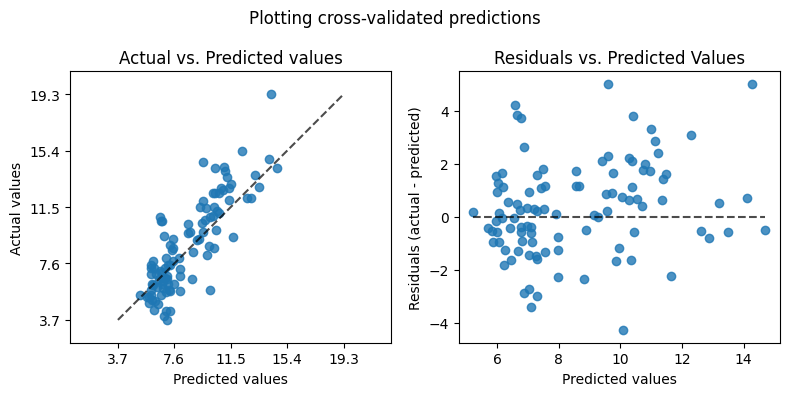

In [7]:
xgb_tuner.show_chart()

2. LGBM Model

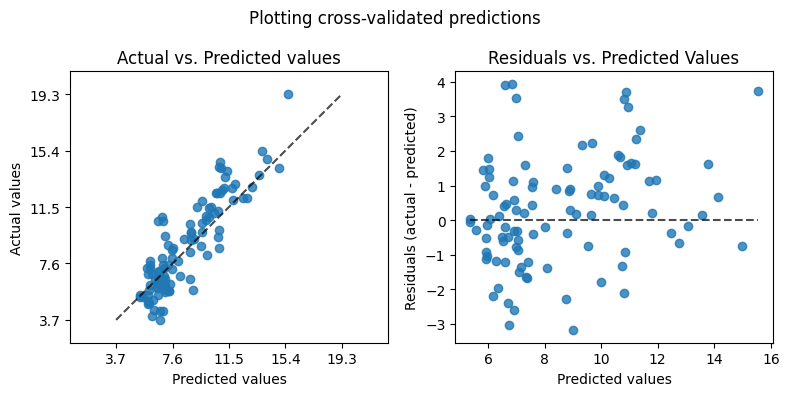

In [8]:
lgbm_tuner.show_chart()

3. HistGradientBoosting Model

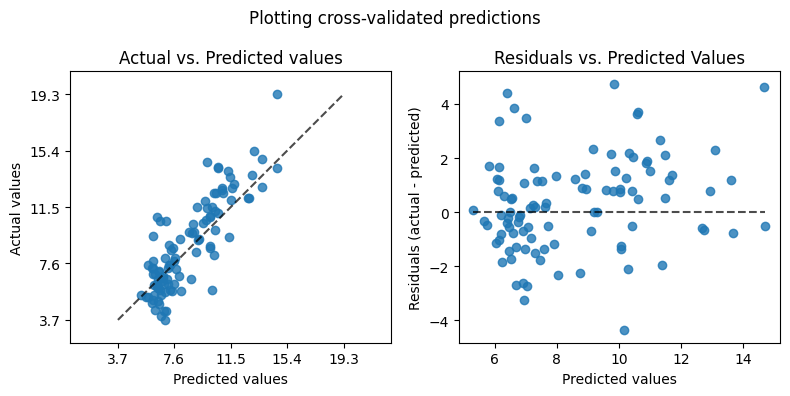

In [9]:
hist_tuner.show_chart()

4. Lasso Model

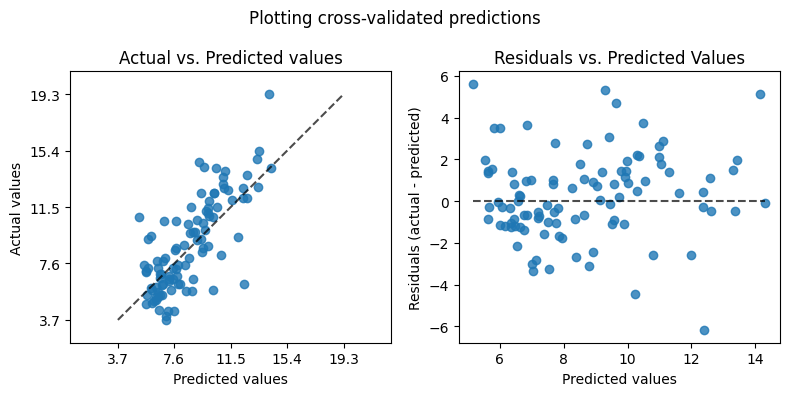

In [10]:
lasso_tuner.show_chart()

5. Ridge Model

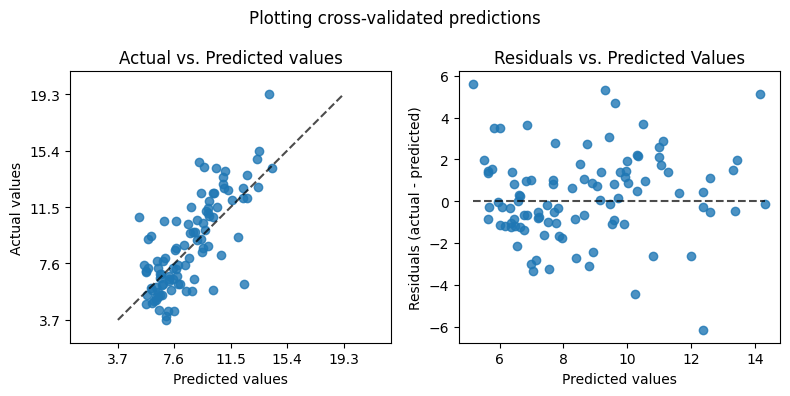

In [11]:
ridge_tuner.show_chart()

6. KNN Model

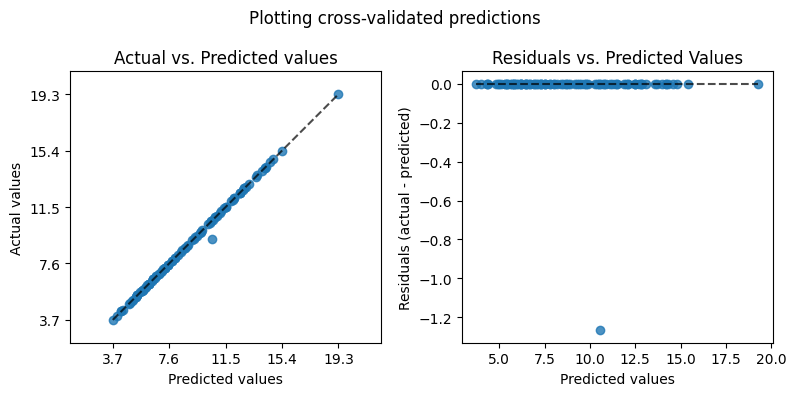

In [12]:
knn_tuner.show_chart()

## Cross-Validated RMSE Scores for Top 100 Features

In [13]:
def train_test_cv(model, name_tag):
    from src.features.helpers.ShapWrapper import ShapWrapper

    print(f'Calculating scores for {name_tag}')

    # Perform cross-validation, specifying both train and test scores
    cv_results = cross_validate(
        model, Xs, y, cv=5,
        scoring=rmse_scorer,
        return_train_score=True
    )

    # Extract train and test scores
    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']

    #Create a results df
    res = pd.DataFrame([{
        'model': name_tag,
        'train_rmse': -1 * train_scores.mean(),
        'test_rmse': -1 * test_scores.mean()
    }])

    return res


In [14]:
xgb_rmse_vals = train_test_cv(knn_best_model, 'XGBoost')
lgbm_rmse_vals = train_test_cv(lgbm_best_model, 'LGBM')
hist_rmse_vals = train_test_cv(hist_best_model, 'HistGradient')
lasso_rmse_vals = train_test_cv(lasso_best_model, 'Lasso')
ridge_rmse_vals = train_test_cv(ridge_best_model, 'Ridge')
knn_rmse_vals = train_test_cv(knn_best_model, 'KNN')
dummy_rmse_vals = train_test_cv(dummy_reg, 'Dummy')

res = pd.concat([
    xgb_rmse_vals, lgbm_rmse_vals, hist_rmse_vals,
    lasso_rmse_vals, ridge_rmse_vals, knn_rmse_vals,
    dummy_rmse_vals
])

res.sort_values('test_rmse', inplace=True)
display(res)

Calculating scores for XGBoost
Calculating scores for LGBM
Calculating scores for HistGradient
Calculating scores for Lasso
Calculating scores for Ridge
Calculating scores for KNN
Calculating scores for Dummy


,model,train_rmse,test_rmse
0,Lasso,2.083482,2.086481
0,Ridge,2.083473,2.086483
0,HistGradient,1.802948,2.094037
0,XGBoost,0.134945,2.110250
0,KNN,0.134945,2.110250
0,LGBM,1.612102,2.126951
0,Dummy,2.993084,3.012515


## Ensemble Model with VotingRegressor

In this step, we will combine the already tuned Regressors into an ensemble model using VotingRegressor. 
* NOTE: Due to it's hihgh degree of overfitting, the KNN model is excluded from the ensemble model.

In [15]:
from sklearn.ensemble import VotingRegressor

# Create a VotingRegressor
voting_regressor = VotingRegressor(estimators=[
    ('lasso', lasso_best_model),
    ('ridge', ridge_best_model),
    ('hist', hist_best_model),
    ('xgb', xgb_best_model),
    ('lgbm', lgbm_best_model)
])

# Fit the ensemble regressor
voting_regressor.fit(Xs, y)

# Calculate CVed RMSE scores for the VotingRegressor
voting_rmse_vals = train_test_cv(voting_regressor, 'Voting Regressor')
voting_rmse_vals

Calculating scores for Voting Regressor


,model,train_rmse,test_rmse
0,Voting Regressor,1.833329,2.056399


**Conclusions:**
* The ensemble model achieves a lower test RMSE (2.056) compared to all individual models.
* The train RMSE (1.833) is reasonable and indicates reduced overfitting compared to individual models like XGBoost and KNN.

## Prepare Kaggle Submission

In [16]:
def prep_submission_table(model, tag):
    print(f'Predicitng with the {tag} model ... \n')
    pred_df = pd.DataFrame({
        'id': Xs_test.index,
        'bg+1:00': model.predict(Xs_test)
    })

    output_name = f'./submissions/{tag}_res.csv'
    pred_df.to_csv(output_name, index=False)
    # display( pred_df )


prep_submission_table(dummy_reg, 'Dummy_Reg')
prep_submission_table(voting_regressor, 'Voting_Reg')
prep_submission_table(lasso_best_model, 'Lasso_Reg')
prep_submission_table(ridge_best_model, 'Ridge_Reg')
prep_submission_table(hist_best_model, 'Hist_Reg')
prep_submission_table(xgb_best_model, 'XGBoost_Reg')
prep_submission_table(knn_best_model, 'KNN_Reg')
prep_submission_table(lgbm_best_model, 'LGBM_Reg')

Predicitng with the Dummy_Reg model ... 

Predicitng with the Voting_Reg model ... 

Predicitng with the Lasso_Reg model ... 

Predicitng with the Ridge_Reg model ... 

Predicitng with the Hist_Reg model ... 

Predicitng with the XGBoost_Reg model ... 

Predicitng with the KNN_Reg model ... 

Predicitng with the LGBM_Reg model ... 



## Kaggle Score Results

For each of the tested models, predictions were generated and submitted to the competition on Kaggle. Below are the **expected RMSE scores** (from cross-validation) and the **Kaggle leaderboard scores**:

| Model      | Expected RMSE | Kaggle Score |
| ----------- | ----------- | ----------- |
| Lasso      | 2.08       | 2.62 |
| Ridge   | 2.08        | 2.62 |
| XGBoost   | 2.11        | 2.59 |
| VotingRegressor   | 2.05        | 2.56 |
<!--
* Lasso : Expected RMSE = 2.08 ;  Kaggle Score = 2.62
* Ridge : Expected RMSE = 2.08 ;  Kaggle Score = 2.62
* XGBoost : Expected RMSE = 2.11  ;  Kaggle Score = 2.59
* VotingRegressor : Expected RMSE = 2.05  ;  Kaggle Score = 2.56
-->

### Summary
* Based on RMSE, correlation, and residual plots, the individual models (Lasso, Ridge, and XGBoost) performed reasonably well when trained on the top important features derived from SHAP analysis.
* Combining the individual models into a VotingRegressor ensemble produces slightly better results to the individual models.
* Kaggle scores were higher (worse) than the RMSE values obtained during our work, obviously due to differences in data distribution in the test set used by Kaggle.